In [1]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
#from createDataset.params import *
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### ADD to main notebook
# Libraries needed for length analysis and adjective ratio
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.types import IntegerType

In [2]:
LOCAL_PATH = "../Project/data/"
WIKI_DATA = os.path.join(LOCAL_PATH, "wikipedia_male_female.json")

In [3]:
# create the session
spark = SparkSession.builder.getOrCreate()

# create the context
sc = spark.sparkContext

# Load data frame
df = spark.read.json(WIKI_DATA)

# Open Gender dictionary
with open('wiki-gender/data/dict_genders.json') as json_file:
    line = json_file.readline()
    dict_genders = json.loads(line)
    
# Open occupations dictionary
dict_occupations = {}
with open('wiki-gender/data/dict_occupations.json') as json_file:
    content = json_file.readlines()
    for line in content:
        occ = json.loads(line)
        dict_occupations.update(occ)
        
# Observation: We need dict_categories_occupations.json in the data folder
# Open occupations categories dictionary
with open('wiki-gender/data/dict_categories_occupations.json') as json_file:
    line = json_file.readline()
    dict_cat_occ = json.loads(line)

# Create function to translate a code into a category
def translate(mapping):
    def translate_(col):
        return mapping.get(col)
    return udf(translate_, StringType())

# Translate gender and occupations codes into corresponding labels
df = df.withColumn('gender', translate(dict_genders)('gender'))\
       .withColumn('occupation', explode(split(regexp_replace(regexp_replace(regexp_replace\
                                (regexp_replace(df['occupation'], '\\[', ''), '\\]', ''), ' ', ''),"'", ""), ",")))\
       .filter(col('occupation') != '')\
       .withColumn('occupation', translate(dict_occupations)('occupation'))\
       .withColumn('field', translate(dict_cat_occ)('occupation'))

df.show()

+------+---------+--------------------+--------------------+--------------------+--------------------+--------------+
|gender|       id|                name|          occupation|            overview|          wiki-title|         field|
+------+---------+--------------------+--------------------+--------------------+--------------------+--------------+
|  male| Q4647941|       A. J. Masters|              singer|Arthur John Masar...|       A. J. Masters|        Artist|
|  male| Q4647941|       A. J. Masters|          songwriter|Arthur John Masar...|       A. J. Masters|        Artist|
|  male| Q4648064|A. L. A. Himmelwr...|      civil engineer|Abraham Lincoln A...|A. L. A. Himmelwr...|          null|
|  male| Q4648064|A. L. A. Himmelwr...|            engineer|Abraham Lincoln A...|A. L. A. Himmelwr...|     Scientist|
|  male| Q4647256|  A. N. Sattampillai|          theologian|Arumai Nayakam Sa...|  A. N. Sattampillai|      Religion|
|  male|   Q84136|         A. Vellayan|      businessper

# Distribution of the Overview's length 
There are very different biographies in the data set, some correspond to Artists, some other to Politicians. The overview's length differs significantly from biography to biography. The largest overview's length is of 23,728 words (without punctiation). The shortest overview's length is of 1. On the following plot we can observe the overview's length distribution. It seems to be a power law distribution with a higher mean than median. 

The distribution's minimum is: 1.00
The distribution's maximum is: 23728.00
The distribution's mean is: 468.50
The distribution's median is: 288.00


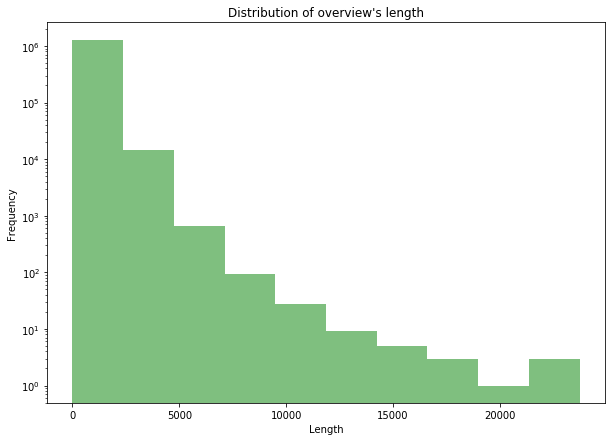

In [4]:
# Remove puncutation from the feature overview
df_overview_len = df.withColumn('overview', regexp_replace(regexp_replace(df['overview'],r'[^\w\s]',''), '\s\s+', ' '))

# Tokenize feature overview
tokenizer = Tokenizer(inputCol="overview", outputCol="overview_tokens")
df_overview_len = tokenizer.transform(df_overview_len)

# Compute length (number of words) of an Overview
tokens_len = udf(lambda s: len(s), IntegerType())
df_overview_len = df_overview_len.withColumn('overview_len', tokens_len(df_overview_len['overview']))

# Query to convert a spark data frame into a pandas data frame, the data frame contains the variables id and overview_len
# Define query
df_overview_len.registerTempTable("df_overview_len")
query = """
SELECT DISTINCT id, overview_len
FROM df_overview_len
WHERE overview_len>0
ORDER BY overview_len
"""

# Execute query
overview_len = spark.sql(query)
# Convert to pandas
overview_len = overview_len.toPandas()

# Print basic statistics
print("The distribution's minimum is: {0:.2f}".format(np.min(overview_len['overview_len'])))
print("The distribution's maximum is: {0:.2f}".format(np.max(overview_len['overview_len'])))
print("The distribution's mean is: {0:.2f}".format(np.mean(overview_len['overview_len'])))
print("The distribution's median is: {0:.2f}".format(np.median(overview_len['overview_len'])))

# Plot the distribution of overview's length
pl_male = overview_len['overview_len'].plot(kind="hist", figsize=(10, 7), log=True, alpha=0.5, color=["green"])
pl_male.set_title('Distribution of overview\'s length')
pl_male.set_xlabel('Length')
pl_male.set_ylabel('Frequency')
plt.show()

# Distribution of the Percentage of adjectives in an overview
The distributions of percentage of adjectives in an overview for Males and Females can be observed below.

In [5]:
# Load data frames that include adjectives in each overview
WIKI_MALE = os.path.join(LOCAL_PATH, "wikipedia_male_adjectives.json")
WIKI_FEM = os.path.join(LOCAL_PATH, "wikipedia_female_adjectives.json")

df_male = spark.read.json(WIKI_MALE)
df_fem = spark.read.json(WIKI_FEM)

In [6]:
# Remove punctuation and compute overview's length, adjective's length, and the percentage of adjectives per overview
df_fem = df_fem.withColumn('overview', regexp_replace(regexp_replace(df_fem['overview'],r'[^\w\s]',''), '\s\s+', ' '))
df_fem = df_fem.withColumn('overview_len', tokens_len(df_fem['overview']))\
               .withColumn('adjective_len', tokens_len(df_fem['adjectives']))
df_fem = df_fem.withColumn('adjective_ratio_overview', df_fem['adjective_len']/df_fem['overview_len'])

# Query to convert a spark data frame into a pandas data frame, the data frame contains the variables id, overview_len, adjective_len, adjective_ratio_overview
# Define query
df_fem.registerTempTable("df_fem")
query = """
SELECT DISTINCT id, overview_len, adjective_len, adjective_ratio_overview 
FROM df_fem
WHERE overview_len>0
ORDER BY adjective_ratio_overview
"""
# Execute query
ratio_adj_overview_fem = spark.sql(query)

# Convert to pandas
ratio_adj_overview_fem = ratio_adj_overview_fem.toPandas()

In [7]:
# Remove punctuation and compute overview's length, adjective's length, and the percentage of adjectives per overview
df_male = df_male.withColumn('overview', regexp_replace(regexp_replace(df_male['overview'],r'[^\w\s]',''), '\s\s+', ' '))
df_male = df_male.withColumn('overview_len', tokens_len(df_male['overview']))\
               .withColumn('adjective_len', tokens_len(df_male['adjectives']))
df_male = df_male.withColumn('adjective_ratio_overview', df_male['adjective_len']/df_male['overview_len'])

# Query to convert a spark data frame into a pandas data frame, the data frame contains the variables id, overview_len, adjective_len, adjective_ratio_overview
# Define query
df_male.registerTempTable("df_male")
query = """
SELECT DISTINCT id, overview_len, adjective_len, adjective_ratio_overview 
FROM df_male
WHERE overview_len>0
ORDER BY adjective_ratio_overview
"""
# Execute query
ratio_adj_overview_male = spark.sql(query)
# Convert to pandas
ratio_adj_overview_male = ratio_adj_overview_male.toPandas()

## Distribution of the Percentage of adjectives in an overview - Female
Overall, each overview does not present a large percentage of adjectives. The distribution for the Female gender is a power law. 

The distribution's minimum is: 0.02%
The distribution's maximum is: 6.67%
The distribution's mean is: 0.35%
The distribution's median is: 0.29%


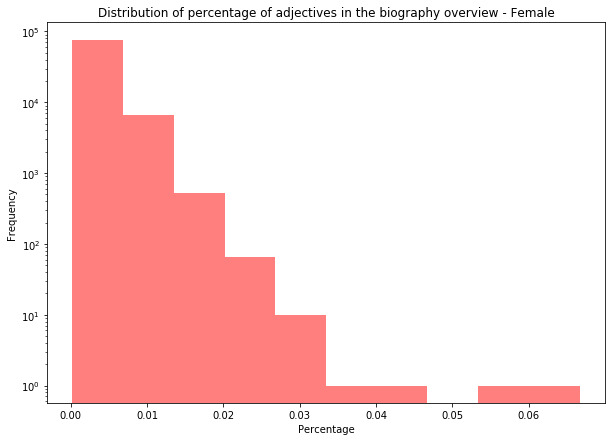

In [8]:
# Print basic statistics
print("The distribution's minimum is: {0:.2f}%".format(np.min(ratio_adj_overview_fem['adjective_ratio_overview']*100)))
print("The distribution's maximum is: {0:.2f}%".format(np.max(ratio_adj_overview_fem['adjective_ratio_overview']*100)))
print("The distribution's mean is: {0:.2f}%".format(np.mean(ratio_adj_overview_fem['adjective_ratio_overview']*100)))
print("The distribution's median is: {0:.2f}%".format(np.median(ratio_adj_overview_fem['adjective_ratio_overview']*100)))

# Plot the distribution of percentage of adjectives in an overview - Female
pl_fem = ratio_adj_overview_fem['adjective_ratio_overview'].plot(kind="hist", figsize=(10, 7), log=True, alpha=0.5, color=["red"])
pl_fem.set_title('Distribution of percentage of adjectives in the biography overview - Female')
pl_fem.set_xlabel('Percentage')
pl_fem.set_ylabel('Frequency')
plt.show()

## Distribution of the Percentage of adjectives in an overview - Male
Overall, each overview does not present a large percentage of adjectives. The distribution for the Male gender is a power law. 

The distribution's minimum is: 0.02%
The distribution's maximum is: 6.67%
The distribution's mean is: 0.35%
The distribution's median is: 0.29%


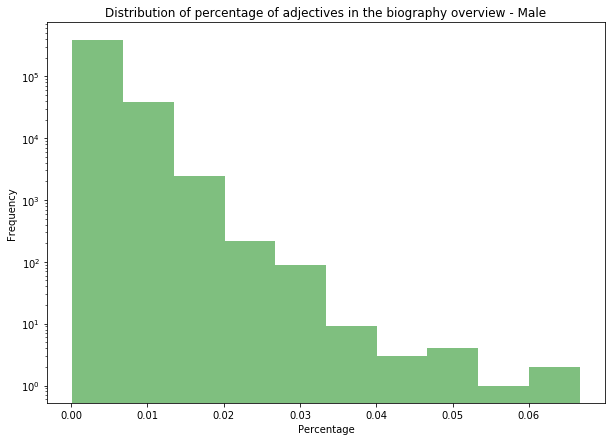

In [9]:
# Print basic statistics
print("The distribution's minimum is: {0:.2f}%".format(np.min(ratio_adj_overview_male['adjective_ratio_overview']*100)))
print("The distribution's maximum is: {0:.2f}%".format(np.max(ratio_adj_overview_male['adjective_ratio_overview']*100)))
print("The distribution's mean is: {0:.2f}%".format(np.mean(ratio_adj_overview_male['adjective_ratio_overview']*100)))
print("The distribution's median is: {0:.2f}%".format(np.median(ratio_adj_overview_male['adjective_ratio_overview']*100)))

# Plot the distribution of percentage of adjectives in an overview - Male
pl_male = ratio_adj_overview_male['adjective_ratio_overview'].plot(kind="hist", figsize=(10, 7), log=True, alpha=0.5, color=["green"])
pl_male.set_title('Distribution of percentage of adjectives in the biography overview - Male')
pl_male.set_xlabel('Percentage')
pl_male.set_ylabel('Frequency')
plt.show()

# Finish

# Eval if the following plot is better than the previous two

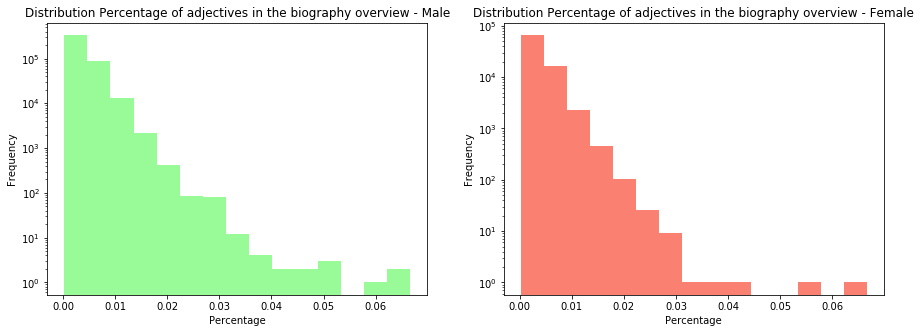

In [27]:
# Plot the histogram of the feature
fig, ax = plt.axsubplots(1,2,figsize=(15,5))
ax[0].hist(ratio_adj_overview_male['adjective_ratio_overview'], bins = 15, color = 'palegreen')
ax[1].hist(ratio_adj_overview_fem['adjective_ratio_overview'], bins = 15, color = 'salmon')

# Tunning the plot
# Setting title, x and y labels
ax[0].set_title('Distribution Percentage of adjectives in the biography overview - Male')
ax[0].set_xlabel('Percentage')
ax[0].set_ylabel('Frequency')
ax[1].set_title('Distribution Percentage of adjectives in the biography overview - Female')
ax[1].set_xlabel('Percentage')
ax[1].set_ylabel('Frequency')

ax[0].set_yscale('log')
ax[1].set_yscale('log')